In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import a6_utils
import cv2
from pathlib import Path

# Exercise 1: Direct PCA method

### a) Write a script to calculate and visualize PCA

In [2]:
with open('data/points.txt', 'r') as file:
    points = np.array(file.read().split()).astype('float').reshape((-1, 2)).T
    
points

array([[1., 6., 5., 1., 0.],
       [0., 2., 4., 3., 1.]])

In [3]:
def pca(X):
    m, N = X.shape
    # calculate the mean value
    mu = 1/N * np.sum(X, axis=1, keepdims=True)
    
    # center the data
    X_d =  X - mu
    
    # compute the covariance matrix
    C = 1/(N-1) * X_d @ X_d.T
    
    U, S, VT = np.linalg.svd(C)
    
    return U, S, VT, mu, C

In [4]:
U, S, VT, mu, C = pca(points)

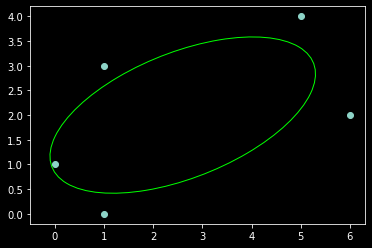

In [5]:
a6_utils.drawEllipse(mu, C)
plt.scatter(points[0], points[1])

### b) Draw the eigenvectors on the plot from the previous task

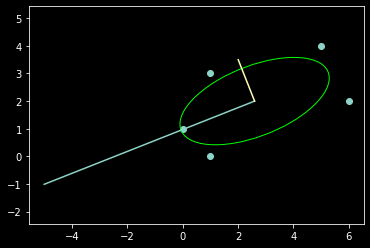

In [6]:
a6_utils.drawEllipse(mu, C)
plt.scatter(points[0], points[1])
plt.plot([mu[0,0], mu[0,0] + U[0,0]*S[0]],[mu[1,0], mu[1,0] + U[1,0]*S[0]])
plt.plot([mu[0,0], mu[0,0] + U[0,1]*S[1]],[mu[1,0], mu[1,0] + U[1,1]*S[1]])
_ = plt.axis('equal')

### c) Plot the cumulative graph of the eigenvalues

<BarContainer object of 2 artists>

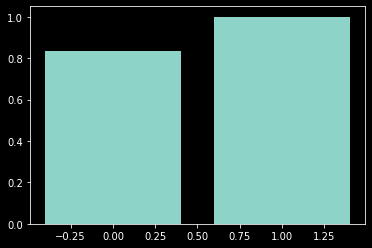

In [7]:
cs = np.cumsum(S)
plt.bar(range(len(cs)), cs/cs[-1])

> About 80%

### d) Now remove the direction of the lowest variance from the input data

In [8]:
# transform to PCA space
points_transformed = U.T @ (points - mu)
# remove last component
points_transformed[-1, :] = 0
#transform back to euclidian space
points_transformed = U @ points_transformed + mu

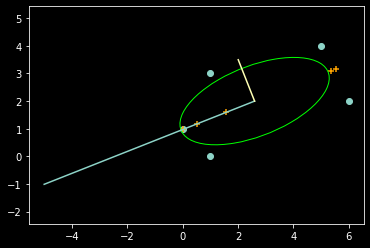

In [9]:
a6_utils.drawEllipse(mu, C)
plt.scatter(points[0], points[1])
plt.plot([mu[0,0], mu[0,0] + U[0,0]*S[0]],[mu[1,0], mu[1,0] + U[1,0]*S[0]])
plt.plot([mu[0,0], mu[0,0] + U[0,1]*S[1]],[mu[1,0], mu[1,0] + U[1,1]*S[1]])
_ = plt.axis('equal')
plt.scatter(points_transformed[0], points_transformed[1], c='orange', marker='+')

__*Question:*__ What happens to the reconstructed points? Where is the data projected
to?

> Points are orthogonally projected on the line defined by $\mu$ and eigen vector with the largest eigen value.

### e) Calculate the closest point to the new sample

In [10]:
q = np.array([3,6])[:,np.newaxis]

# transform to PCA space
q_t = U.T @ (q - mu)
# remove last component
q_t[-1, :] = 0
#transform back to euclidian space
q_t = U @ q_t + mu

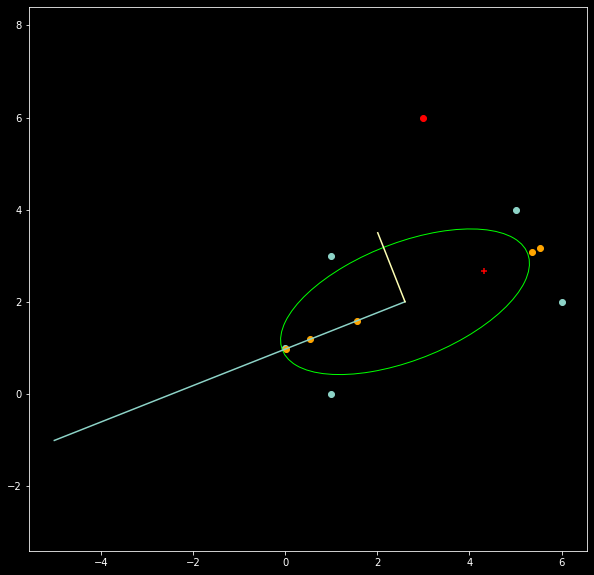

In [11]:
plt.figure(figsize=(10,10))
a6_utils.drawEllipse(mu, C)
plt.scatter(points[0], points[1])
plt.plot([mu[0,0], mu[0,0] + U[0,0]*S[0]],[mu[1,0], mu[1,0] + U[0,1]*S[0]])
plt.plot([mu[0,0], mu[0,0] + U[1,0]*S[1]],[mu[1,0], mu[1,0] + U[1,1]*S[1]])
_ = plt.axis('equal')
plt.scatter(points_transformed[0], points_transformed[1], c='orange')
plt.scatter(q[0], q[1], c='red')
plt.scatter(q_t[0], q_t[1], c='red', marker='+')


In [12]:
np.mean(points, axis=1)

array([2.6, 2. ])

In [13]:
min_d = np.inf
min_p = None
min_i = None
for i, p in enumerate(points.T):
    d = np.linalg.norm(p - q.flatten())
    if d < min_d :
        min_d, min_p, min_i = d, p, i
        
print(f"Point {q.flatten()} in the closest to {min_p} (index: {min_i}).")
        

Point [3 6] in the closest to [5. 4.] (index: 2).


In [14]:
min_d = np.inf
min_p = None
min_i = None
for i, p in enumerate(points_transformed.T):
    d = np.linalg.norm(p - q_t.flatten())
    if d < min_d :
        min_d, min_p, min_i = d, p, i
        
print(f"Point {q_t.flatten()} in the closest to {min_p} (index: {min_i}).")

Point [4.3137897  2.67771382] in the closest to [5.35938577 3.09119215] (index: 2).


# Exercise 2: The dual PCA method

In [15]:
def pca2(X):
    m, N = X.shape

    # calculate the mean value
    mu = np.mean(X, axis=1, keepdims=True)
    
    # center the data
    X_d =  X - mu
    
    # compute the dual covariance matrix
    C_ = 1/(N-1) * (X_d.T @ X_d)
    
    # SVD of dual covariance matrix
    U, S, VT = np.linalg.svd(C_)
    
    U = X_d @ U @ np.diag(np.sqrt(1/(S*(N-1))))

    return U, S, VT, mu, C_

In [16]:
U, S, VT, mu, C_ = pca2(points)

In [17]:
# transform to PCA space
points_transformed = U.T @ (points - mu)

#transform back to euclidian space
points_transformed = U @ points_transformed + mu

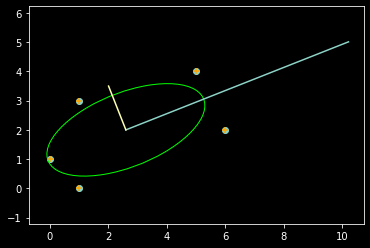

In [18]:
a6_utils.drawEllipse(mu, C)
plt.scatter(points[0], points[1])
plt.plot([mu[0,0], mu[0,0] + U[0,0]*S[0]],[mu[1,0], mu[1,0] + U[1,0]*S[0]])
plt.plot([mu[0,0], mu[0,0] + U[0,1]*S[1]],[mu[1,0], mu[1,0] + U[1,1]*S[1]])
_ = plt.axis('equal')
plt.scatter(points_transformed[0], points_transformed[1], c='orange', marker='+')

# Exercise 3: Image decomposition examples

### a) Data preparation

In [19]:
def load_dataset(i):
    path = Path(f"data/faces/{i}")
    imgs = []
    for p in path.iterdir():
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2GRAY).astype('float64')
        imgs.append(img.flatten())
        
    return np.array(imgs)

In [20]:
dataset1 = load_dataset(1)
dataset2 = load_dataset(2)
dataset3 = load_dataset(3)

In [21]:
dataset1.shape

(64, 8064)

### b) Using dual PCA

In [22]:
U, S, VT, mu, C_ = pca2(dataset1.T)

First eigen vectors

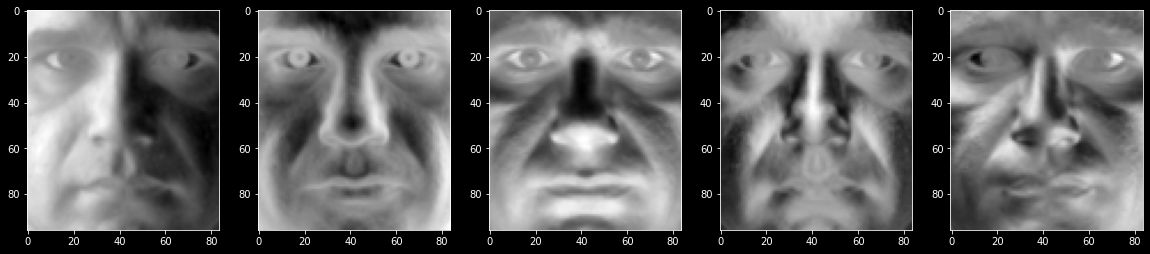

In [23]:
plt.figure(figsize=(20,5))
for i in range(5):
	plt.subplot(1,5,i+1)
	plt.imshow(U[:,i].reshape((96, 84)), cmap="gray")

Reprojection

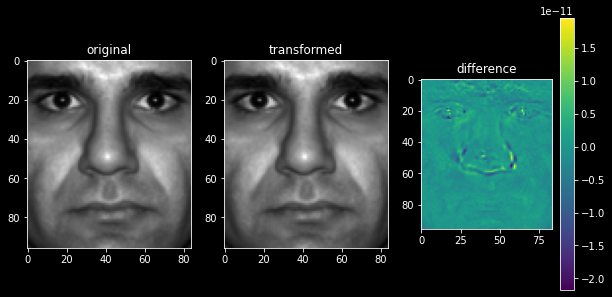

In [24]:
example = dataset1[0]

example_pca = U.T @ (example.reshape((-1, 1)) - mu)
example_transformesd = U @ example_pca + mu

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("original")
plt.imshow(example.reshape((96,84)), cmap="gray")
plt.subplot(1,3,2)
plt.title("transformed")
plt.imshow(example_transformesd.reshape((96,84)), cmap="gray")
plt.subplot(1,3,3)
plt.title("difference")
plt.imshow(example_transformesd.reshape((96,84)) - example.reshape((96,84)))
plt.colorbar()

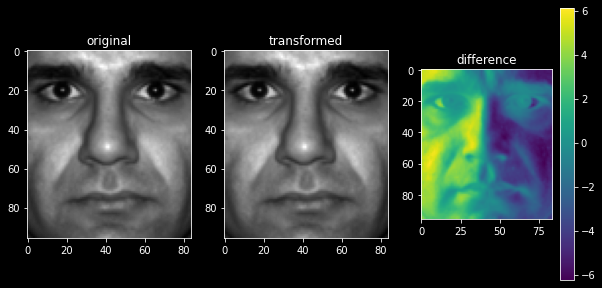

In [25]:
example = dataset1[0]

example_pca = U.T @ (example.reshape((-1, 1)) - mu)
example_pca[0] = 0
example_transformesd = U @ example_pca + mu

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("original")
plt.imshow(example.reshape((96,84)), cmap="gray")
plt.subplot(1,3,2)
plt.title("transformed")
plt.imshow(example_transformesd.reshape((96,84)), cmap="gray")
plt.subplot(1,3,3)
plt.title("difference")
plt.imshow(example_transformesd.reshape((96,84)) - example.reshape((96,84)))
plt.colorbar()


### c) Effect of the number of components on the reconstruction

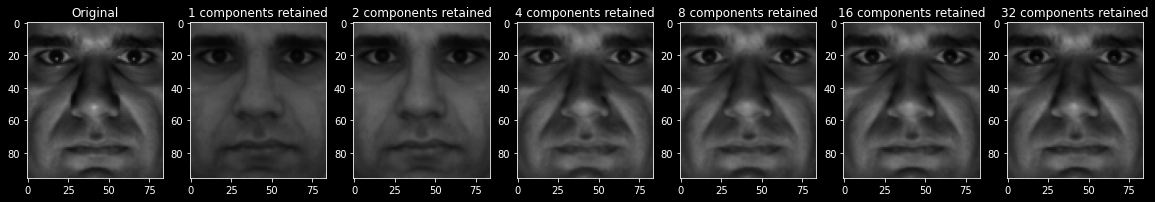

In [26]:
example = dataset1[3]

N = 6
example_pca = U.T @ (example.reshape((-1, 1)) - mu)

plt.figure(figsize=(20,5))
plt.subplot(1, N+1, 1)
plt.title("Original")
plt.imshow(example.reshape((96, 84)), cmap="gray", vmax=255, vmin=0)

for i in range(6):
    p = 2**i
    
    example_pca_reduce = example_pca.copy()
    example_pca_reduce[p:] = 0
    example_transformesd = U @ example_pca_reduce + mu
    
    
    plt.subplot(1, N+1, i+2)
    plt.title(f"{p} components retained")
    plt.imshow(example_transformesd.reshape((96,84)), cmap="gray", vmax=255, vmin=0)

### d) Informativeness of each component

In [27]:
U, S, VT, mu, C_ = pca2(dataset2.T)

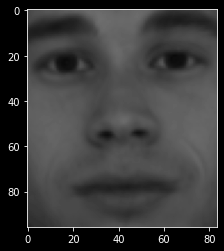

In [28]:
avg_face = dataset2.mean(axis=0)
plt.imshow(avg_face.reshape((96, 84)), cmap="gray", vmin=0, vmax=255)

avg_face_pca = U.T @ (avg_face.reshape((-1, 1)) - mu)


In [29]:
fig, ax = plt.subplots()

fi = np.linspace(0, 2*np.pi, 100)
k = 3000

def animate(i):
    avg_face_pca[0] = np.sin(fi[i]) * k
    avg_face_pca[1] = np.cos(fi[i]) * k
    
    avg_face_transformed = U @ avg_face_pca + mu
    
    ax.imshow(avg_face_transformed.reshape((96, 84)), cmap="gray")
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(fi))
plt.close()

HTML(ani.to_jshtml())


### e) Reconstruction of a foreign image

In [30]:
U, S, VT, mu, C_ = pca2(dataset1.T)

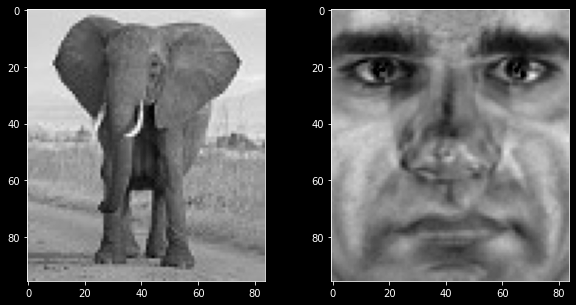

In [31]:
plt.figure(figsize=(10, 5))
elephant = cv2.cvtColor(cv2.imread("data/elephant.jpg"), cv2.COLOR_BGR2GRAY).astype('float64').flatten()
plt.subplot(1, 2, 1)
plt.imshow(elephant.reshape((96, 84)), cmap="gray")

elephant_pca = U.T @ (elephant.reshape((-1, 1)) - mu)
elephant_transformesd = U @ elephant_pca + mu
plt.subplot(1, 2, 2)
plt.imshow(elephant_transformesd.reshape((96, 84)), cmap="gray", vmin=0, vmax=255)

### g) Linear discriminant analysis

In [32]:
dataset = np.concatenate((dataset1, dataset2, dataset3))
dataset /= 256

In [33]:
U, S, VT, mu, C_ = pca2(dataset.T)

In [34]:
# transform to PCA space
dataset_pca = U.T @ (dataset.T - mu)

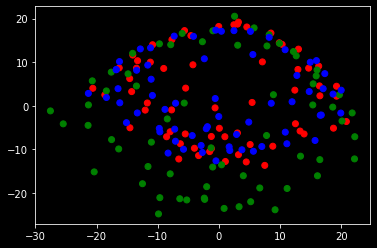

In [35]:
plt.scatter(dataset_pca[0], dataset_pca[1], c=['r']*64 + ['g']*64 + ['b']*64 )

In [36]:
def lda(X, c, n):
    # X: input samples in columns, arranged by classes
    # c, n: number of classes, number of samples per class
    # W: LDA subspace basis vectors
    SB = np.zeros((len(X), len(X))) # between class scatter
    SW = np.zeros((len(X), len(X))) # within class scatter
    Ms = np.zeros((len(X),c)) # class means in the LDA subspace
    MM = X.mean(axis=1, keepdims=True)
    for i in range(c):
        Ms[:,i] = X[:,i*n: (i+1)*n].mean(axis=1)
        SB += n * (Ms[:,[i]] - MM) @ (Ms[:,[i]] - MM).T
        for j in range(n):
            a = (X[:, [i*n+j]] - Ms[:,[i]]) @ (X[:, [i*n+j]] - Ms[:,[i]]).T
            SW += a
     
    W, V = np.linalg.eig(np.linalg.inv(SW) @ SB)

    Wabs = np.abs(W)
    I = np.argsort(-Wabs)[:c]
    W = W[I]
    V = V[:,I]
    Ms = V.T @ Ms
    
    return V, MM    

In [37]:
X = dataset_pca[:30]
V, MM = lda(X, 3, 64)

dataset_lda = V.T @ (X - MM)

C:\Users\njeze\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


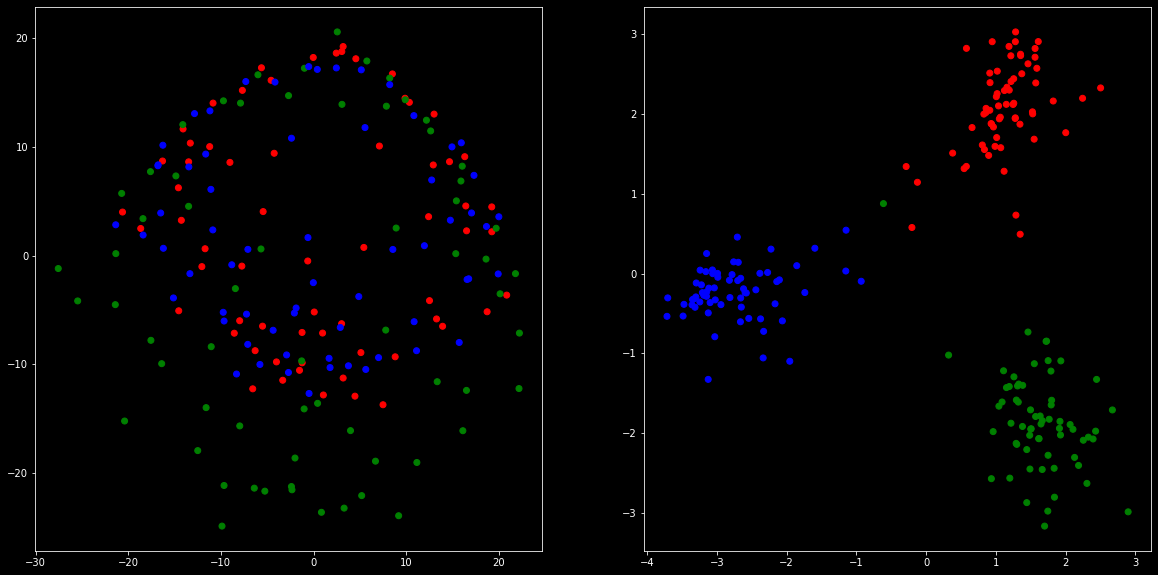

In [38]:
plt.figure(figsize=(20, 10))
_ = plt.axis('equal')
plt.subplot(1,2,1)
plt.scatter(dataset_pca[0], dataset_pca[1], c=['r']*64 + ['g']*64 + ['b']*64 )
plt.subplot(1,2,2)
plt.scatter(dataset_lda[0], dataset_lda[1], c=['r']*64 + ['g']*64 + ['b']*64 )
